In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

### PMT has 13 resistors; 330 k$\Omega$ per resistor
Output voltage after two 5x SR445A amplification stages is 27 mV  
(From `2020_3_11.hdf`)

In [2]:
Ramp = 50*u.Ohm
R = 330*u.kOhm
gain = 5*5
Vout = 80*u.mV/gain
Vpmt = 1*u.kV

PMT output current

In [3]:
Ipmt = (Vout/Ramp).to(u.A)
Ipmt.to(u.mA)

<Quantity 0.064 mA>

Voltage divider current

In [4]:
Idiv = (Vpmt/(12*R)).to(u.A)
Idiv.to(u.mA)

<Quantity 0.25252525 mA>

In [5]:
ratio = Ipmt/Idiv
ratio

<Quantity 0.25344>

Hamamatsu R375 gain @1 kV is $\sim 5\times 10^5$; gain @500 V is $\sim 6\times 10^3$ (approximated from datasheet)

In [6]:
def log_linear_linear_func(x,y):
    return lambda z: y[0]*np.exp((z-x[0])/(x[1]-x[0]) * np.log(y[1]/y[0]))

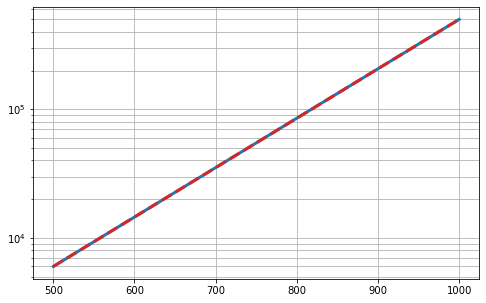

In [7]:
v = np.array([500, 1000])
g = np.array([6e3,5e5])

vi = np.linspace(min(v), max(v),101)

m = np.log(g[1]/g[0])/np.diff(v)

gain_fun = log_linear_linear_func(v,g)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(v,g, lw = 3)
ax.plot(vi,gain_fun(vi), '--C3', lw = 3)
ax.set_yscale('log')
ax.grid(True, which = 'both')

In [8]:
def div_current(V,R):
    return V/(12*R)

def pmt_current(V):
    return (Ipmt.value/gain_fun(1e3))*gain_fun(V)

def ratio(V,R):
    return pmt_current(V)/div_current(V,R)

def voltage_output(V,amp,R=50):
    return pmt_current(V)*R*amp

### Around a ratio of 0.07 the PMT current becomes non-linear (straight line in plot below)

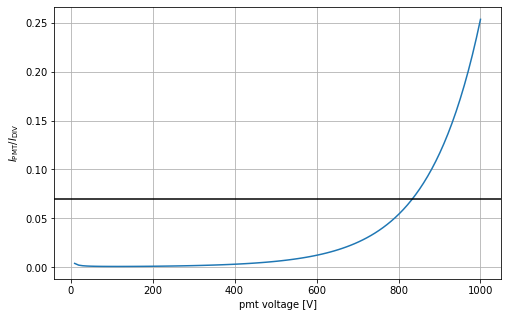

In [9]:
v = np.linspace(10,1e3,101)
rat = ratio(v, R.to(u.ohm).value)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(v, rat)

ax.set_xlabel('pmt voltage [V]')
ax.set_ylabel(r'$I_{\rm PMT}/I_{\rm DIV}$')

ax.axhline(0.07, color ='k')
ax.grid(True, which = 'both')

In [10]:
v = np.linspace(500,1.1e3,501)
r = np.linspace(50,330,501)*1e3
v_m, r_m = np.meshgrid(v,r)
rat = ratio(v_m, r_m)

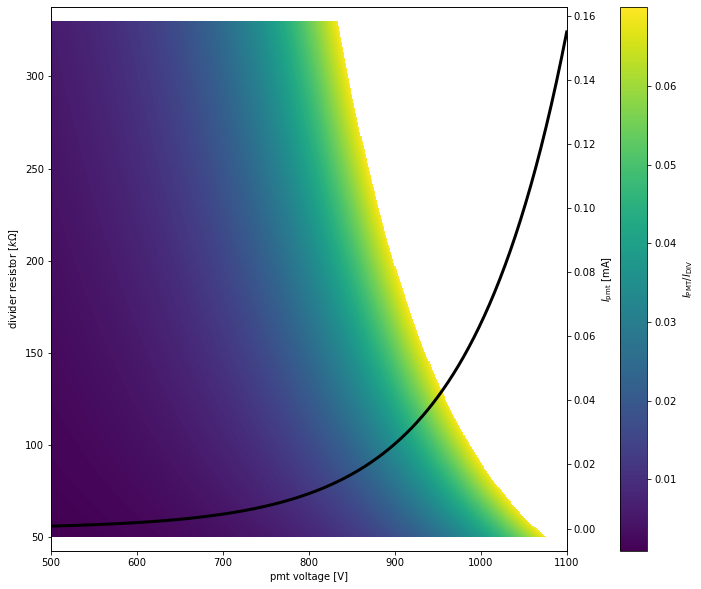

In [11]:
import copy
import matplotlib

cmap = copy.copy(matplotlib.cm.viridis)  # Can be any colormap that you want after the cm
cmap.set_bad(color='white')

masked_array = np.ma.masked_where(rat > 0.07, rat)

fig, ax = plt.subplots(figsize = (12,10))
cbar = ax.imshow(masked_array, origin = 'lower', extent = (v.min(), v.max(), r.min()/1e3, r.max()/1e3))
ax.set_aspect(np.ptp(v)/(np.ptp(r)/1e3))

cbar = fig.colorbar(cbar, pad = 0.08)
cbar.set_label(r'$I_{\rm PMT}/I_{\rm DIV}$')

ax.set_xlabel('pmt voltage [V]')
ax.set_ylabel(r'divider resistor [$k\Omega$]');

ax1 = ax.twinx()
ax1.plot(v,pmt_current(v)*1e3, color = 'k', lw = 3)
ax1.set_ylabel(r'$I_{\rm pmt}$ [mA]');

In [12]:
from scipy.optimize import minimize_scalar

mfun = lambda x: (ratio(x,330e3)-0.07)**2

res330 = minimize_scalar(mfun, bracket = [500,1e3])
res330

     fun: 2.243410479285844e-20
    nfev: 19
     nit: 15
 success: True
       x: 834.0303404724189

so at 330 $k\Omega$ saturation happens around 834 V; calculate amplification needed to get same signal as at 1 kV

In [13]:
pmt_current(1e3)/pmt_current(res330.x)

4.341054809557208

compared to the two stages required @1 kV need 1 extra stage  
replace resistors in divider circuit with 75 $k\Omega$

In [14]:
mfun = lambda x: (ratio(x,75e3)-0.07)**2

res75 = minimize_scalar(mfun, bracket = [500,1e3])
res75

     fun: 4.187827900689771e-21
    nfev: 18
     nit: 14
 success: True
       x: 1024.8123069960104

So around 928 V you reach saturation

In [15]:
pmt_current(1e3)/pmt_current(res75.x)

0.8029344851531268

Wouldn't need any amplification stages

In [16]:
pmt_current(res75.x)/pmt_current(res330.x)

5.4064869423678195

With only a single extra amplification stage the need for the resistor divider circuit replacement would be negated. Can also switch to 500 Ohm input impedance to gain a factor 10 without any additional input noise. This will amplify the PMT noise by a factor 10 too.

### Noise introduced by the SR445A

The SR445A has 6.4 ${\rm nV}/\sqrt{\rm Hz}$ input noise (per stage).  
So with a 100 kHz lowpass

In [67]:
noise = 6.4*1e-9 * np.sqrt(100e3)
print(f'{noise*1e3*5:.2f} mV noise for one stage')

0.01 mV noise for one stage


In [68]:
def total_noise(noise, bandwidth, stages, amp = 5):
    n = noise*np.sqrt(bandwidth)
    return np.sum([n* (5**(i)) for i in range(1,stages+1)])

In [75]:
bw = 1e5
noise = total_noise(6.4e-9, bw, 1)
print(f'{noise*1e3:.2f} mV noise for one stage')
noise = total_noise(6.4e-9, bw, 2)
print(f'{noise*1e3:.2f} mV noise for two stages')
noise = total_noise(6.4e-9, bw, 3)
print(f'{noise*1e3:.2f} mV noise for three stages')
noise = total_noise(6.4e-9, bw, 4)
print(f'{noise*1e3:.2f} mV noise for four stages')

0.01 mV noise for one stage
0.06 mV noise for two stages
0.31 mV noise for three stages
1.58 mV noise for four stages
